In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import shutil
from mpl_toolkits.mplot3d import Axes3D
from six.moves import cPickle

import pandas as pd

from sklearn.preprocessing import OneHotEncoder

from RNN import RNNmodel

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 데이터 불러오기 및 추출
- 같은날 점심 불러오기

In [2]:
peopleDfRaw = cPickle.load(open('../../../../data/pickle/rawPickle/people.pkl', 'rb'))
#menuDfraw = cPickle.load(open('../data/menu.pkl', 'rb'))

In [3]:
peopleDfRaw.head(5)

,date,type,values,type2,type1
1,2003-03-01,아침식사,37.472924,morning,morning
2,2003-03-01,점심식사,31.191336,lunch_kor,lunch
3,2003-03-01,저녁식사,19.566787,dinner,dinner
4,2003-03-02,아침식사,36.101083,morning,morning
5,2003-03-02,점심식사,33.357401,lunch_kor,lunch


In [4]:
# groupby를 쓰면 손쉽게 두가지 조건에 맞는 연산을 할 수 있다 (ex. 같은 date에서 같은 type1끼리 합쳐줘)

peopleDfSumType1 = peopleDfRaw.groupby(['date', 'type2']).sum().reset_index()

In [5]:
peopleDfSumType1['type2'].unique()

array(['dinner', 'lunch_kor', 'morning', 'lunch_west'], dtype=object)

- date time 처리하기 (numpy 버전)

```python
dates = np.arange(np.datetime64('2000-01-01'), np.datetime64('2010-01-01'))
years = dates.astype('datetime64[Y]').astype(int) + 1970
months = dates.astype('datetime64[M]').astype(int) % 12 + 1
days = dates - dates.astype('datetime64[M]') + 1
```


In [6]:
# date = peopleDfSumType1.loc[peopleDfSumType1['type1'] == 'lunch'].date.values
# people = peopleDfSumType1.loc[peopleDfSumType1['type1'] == 'lunch'].values[:, 2]

- 동 / 서 각각 예측할 생각
- 틀리는 부분을 메뉴로 예측!

- 요일정보 추가
- The day of the week with Monday=0, Sunday=6

In [7]:
peopleDfKor = peopleDfSumType1.loc[peopleDfSumType1['type2'] == 'lunch_kor'][['date', 'values']]
peopleDfWest = peopleDfSumType1.loc[peopleDfSumType1['type2'] == 'lunch_west'][['date', 'values']]

peopleDfKor = peopleDfKor.set_index('date')
peopleDfWest = peopleDfWest.set_index('date')

peopleDfKor['values_west'] = peopleDfWest['values']

peopleDfMerge = peopleDfKor.reset_index()
peopleDfMerge.columns = ['date', 'values_kor', 'values_west']
peopleDfMerge.values_west.loc[peopleDfMerge.values_west.isnull()] = 0
peopleDfMerge['values_sum'] = peopleDfMerge['values_kor']+peopleDfMerge['values_west']

peopleDfMerge = peopleDfMerge.set_index('date')

peopleDfMerge['weekday'] = peopleDfMerge.index.weekday
peopleDfMerge = peopleDfMerge.reset_index()

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


- 데이터구성 확인하기. 주말때문에 두줄로 나눠진다. 

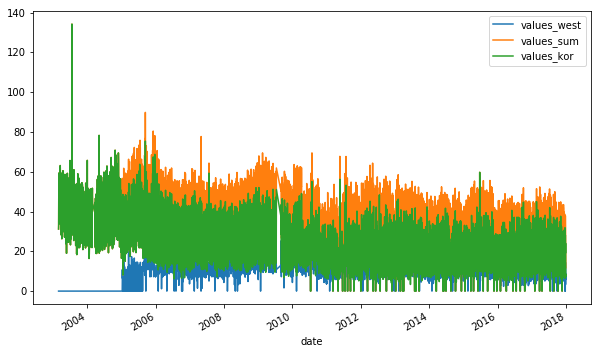

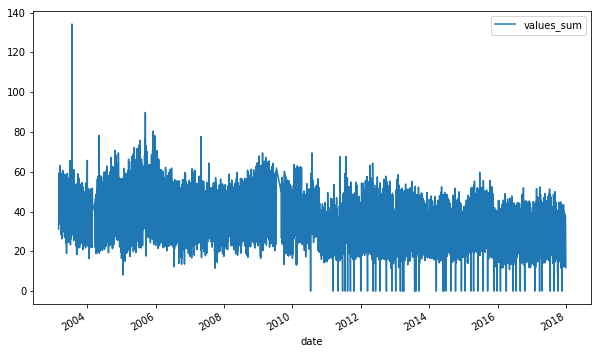

In [8]:
peopleDfMerge[['date', 'values_west', 'values_sum','values_kor']].set_index('date').plot(figsize=(10,6))
plt.show()
peopleDfMerge[['date','values_sum']].set_index('date').plot(figsize=(10,6))
plt.show()

In [9]:
peopleDfMerge.to_pickle('MergeDataLunch.pkl')

# 특이사항확인하기
- 공휴일 추가하기

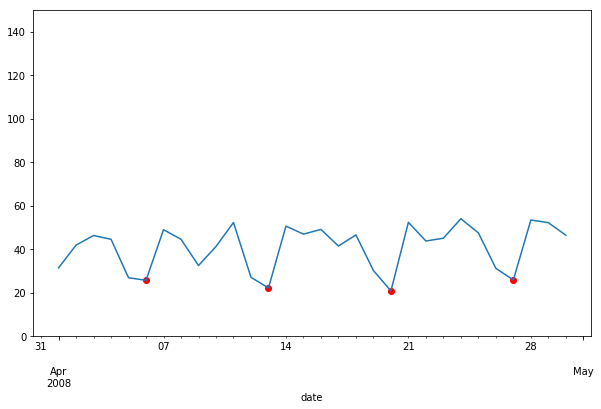

In [10]:
start_date = '2008-04-01'
end_date = '2008-04-30'
holyday = '2008-05-26'
pointList = peopleDfMerge.loc[peopleDfMerge.weekday == 6].set_index('date')\
                .values_sum[start_date:end_date].reset_index().values

peopleDfMerge.set_index('date').values_sum[start_date:end_date].plot(figsize=(10, 6))
# peopleDfMerge.set_index('date').values_kor['2004-03-01':'2004-05-31']\
#             .loc[peopleDfMerge.set_index('date').weekday['2004-03-01':'2004-05-31'] == 6]

plt.ylim(0, 150)
for date, value in pointList:
    plt.scatter(str(date)[:10], value, c='r')
#plt.vlines(holyday, 0, 150, 'r')

# 휴일 등록하기

In [11]:
peopleDfMerge['holiday']=0

In [12]:
holidayList =['0101', '0301', '0505', '0606', '0815', '1003', '1225']

holidayIdx = []
for _year in range(2003, 2018):
    for _date in holidayList:
        print (_year, _date)
        try:
            idx = np.where(peopleDfMerge['date'].apply(
                lambda x: (x.year == _year)  & (x.month == int(_date[:2])) & (x.day == int(_date[2:]))
                ).values)[0][0]
            holidayIdx.append(idx)
        except IndexError:
            pass
        

2003 0101
2003 0301
2003 0505
2003 0606
2003 0815
2003 1003
2003 1225
2004 0101
2004 0301
2004 0505
2004 0606
2004 0815
2004 1003
2004 1225
2005 0101
2005 0301
2005 0505
2005 0606
2005 0815
2005 1003
2005 1225
2006 0101
2006 0301
2006 0505
2006 0606
2006 0815
2006 1003
2006 1225
2007 0101
2007 0301
2007 0505
2007 0606
2007 0815
2007 1003
2007 1225
2008 0101
2008 0301
2008 0505
2008 0606
2008 0815
2008 1003
2008 1225
2009 0101
2009 0301
2009 0505
2009 0606
2009 0815
2009 1003
2009 1225
2010 0101
2010 0301
2010 0505
2010 0606
2010 0815
2010 1003
2010 1225
2011 0101
2011 0301
2011 0505
2011 0606
2011 0815
2011 1003
2011 1225
2012 0101
2012 0301
2012 0505
2012 0606
2012 0815
2012 1003
2012 1225
2013 0101
2013 0301
2013 0505
2013 0606
2013 0815
2013 1003
2013 1225
2014 0101
2014 0301
2014 0505
2014 0606
2014 0815
2014 1003
2014 1225
2015 0101
2015 0301
2015 0505
2015 0606
2015 0815
2015 1003
2015 1225
2016 0101
2016 0301
2016 0505
2016 0606
2016 0815
2016 1003
2016 1225
2017 0101
2017 0301


In [13]:
peopleDfMerge.loc[holidayIdx, 'holiday'] = 1

In [14]:
peopleDfMerge.to_pickle('AllData.pkl')

# RNN 인풋 만들기

- 2011년을 기점으로 식사량이 줄어듦
    - 줄어드는 기점을 포함할지 말지 고민할것
- ISSUE
    - 식수인원 부분에 date자체가 누락된 경우가 있음 (74일)
    - RNN input의경우 총길이를 30일이라고 할경우 연속되어야함 따라서 데이터 전처리과정에서 저 누락된부분 처리필요

- 누락된 날짜확인

- 빨간날 추가해놔야함

## 맞춰야하는 날짜 확인

In [15]:
len(peopleDfMerge[peopleDfMerge['values_sum'] == 0])

150

In [16]:
peopleDfMerge[peopleDfMerge['values_sum'] == 0].head()

,date,values_kor,values_west,values_sum,weekday,holiday
2615,2010-07-13,0.0,0.0,0.0,1,0
2616,2010-07-14,0.0,0.0,0.0,2,0
2617,2010-07-15,0.0,0.0,0.0,3,0
2854,2011-03-09,0.0,0.0,0.0,2,0
2855,2011-03-10,0.0,0.0,0.0,3,0


- 0인날 찾기 작업시작

In [17]:

peopleDfMerge = peopleDfMerge.set_index('date')
peopleDfMerge = peopleDfMerge.resample('1D').sum()

In [18]:
len(peopleDfMerge[peopleDfMerge['values_sum'] == 0])

227

In [19]:

peopleDfMerge = peopleDfMerge.reset_index()

In [20]:
peopleDfMerge[peopleDfMerge['values_sum'] == 0].index

Int64Index([ 104,  364,  365,  366,  367,  368,  369,  370,  371,  372,
            ...
            5253, 5290, 5291, 5292, 5335, 5336, 5337, 5378, 5379, 5380],
           dtype='int64', length=227)

In [21]:
peopleDfMerge[peopleDfMerge['values_sum'] == 0].head()

,date,values_kor,values_west,values_sum,weekday,holiday
104,2003-06-13,0.0,0.0,0.0,0,0
364,2004-02-28,0.0,0.0,0.0,0,0
365,2004-02-29,0.0,0.0,0.0,0,0
366,2004-03-01,0.0,0.0,0.0,0,0
367,2004-03-02,0.0,0.0,0.0,0,0


# 학습/검증 구간 분리

- 총 5420일

In [22]:
# count가  0일인 것만 추출
zero_idx = peopleDfMerge[peopleDfMerge['values_sum'] == 0].index

In [23]:
zero_idx

Int64Index([ 104,  364,  365,  366,  367,  368,  369,  370,  371,  372,
            ...
            5253, 5290, 5291, 5292, 5335, 5336, 5337, 5378, 5379, 5380],
           dtype='int64', length=227)

In [24]:
# 시작지점과 끝나는 지점 추출
before_idx = zero_idx[-1]
end_index = [zero_idx[-1]]
start_index = [0]
for i, idx in enumerate(zero_idx):
    if idx != before_idx+1:
        end_index.append(idx)
    if idx-1 != before_idx:
        start_index.append(zero_idx[i-1])
    before_idx = zero_idx[i]
start_index = np.sort(start_index)
end_index = np.sort(end_index)

* 227개의 식수인원 0이 등장하는데 그중에서 150개가 문제를 위한 식수인원 0, 따라서 그 직전을 맞추는 것이 좋음,
- RNN의 input으로는 30일의 정보가 들어감 -> 따라서 총 33일 버퍼는 있어야, valid에 30 맞출 3일 생김.

## 학습 검증 데이터 완성

- 특이사항 : 학습데이터의 경우 end -3 일까지만 집어넣는다 (3일은 맞춰야하는날) / 검증데이터는 -33일치 집어넣음 (앞에 30일을 이용해서 뒤에3일 맞춤)

In [74]:
intervalDay = 3

# end index 부터 start index 까지 쓰는거, end - start 차가 66보다 작으면 넘어감
use_interval = []
for start, end in zip(start_index, end_index):
    if end-start>intervalDay+3:
        use_interval.append((start+1, end))
use_interval

[(1, 104),
 (105, 364),
 (387, 1499),
 (1500, 1744),
 (1745, 2129),
 (2130, 2153),
 (2154, 2328),
 (2376, 2691),
 (2694, 2930),
 (2933, 2985),
 (2988, 3033),
 (3036, 3059),
 (3062, 3086),
 (3089, 3117),
 (3120, 3153),
 (3156, 3228),
 (3231, 3299),
 (3302, 3359),
 (3362, 3385),
 (3388, 3409),
 (3410, 3434),
 (3437, 3501),
 (3504, 3560),
 (3563, 3600),
 (3603, 3650),
 (3653, 3674),
 (3677, 3685),
 (3688, 3803),
 (3806, 3816),
 (3819, 3850),
 (3853, 4034),
 (4037, 4105),
 (4116, 4138),
 (4141, 4190),
 (4193, 4239),
 (4242, 4302),
 (4305, 4341),
 (4344, 4403),
 (4406, 4432),
 (4435, 4479),
 (4482, 4535),
 (4538, 4582),
 (4585, 4650),
 (4653, 4680),
 (4683, 4719),
 (4722, 4782),
 (4785, 4853),
 (4856, 4888),
 (4891, 4931),
 (4934, 4979),
 (4982, 5086),
 (5089, 5137),
 (5140, 5163),
 (5166, 5251),
 (5254, 5290),
 (5293, 5335),
 (5338, 5378)]

In [75]:
use_interval

[(1, 104),
 (105, 364),
 (387, 1499),
 (1500, 1744),
 (1745, 2129),
 (2130, 2153),
 (2154, 2328),
 (2376, 2691),
 (2694, 2930),
 (2933, 2985),
 (2988, 3033),
 (3036, 3059),
 (3062, 3086),
 (3089, 3117),
 (3120, 3153),
 (3156, 3228),
 (3231, 3299),
 (3302, 3359),
 (3362, 3385),
 (3388, 3409),
 (3410, 3434),
 (3437, 3501),
 (3504, 3560),
 (3563, 3600),
 (3603, 3650),
 (3653, 3674),
 (3677, 3685),
 (3688, 3803),
 (3806, 3816),
 (3819, 3850),
 (3853, 4034),
 (4037, 4105),
 (4116, 4138),
 (4141, 4190),
 (4193, 4239),
 (4242, 4302),
 (4305, 4341),
 (4344, 4403),
 (4406, 4432),
 (4435, 4479),
 (4482, 4535),
 (4538, 4582),
 (4585, 4650),
 (4653, 4680),
 (4683, 4719),
 (4722, 4782),
 (4785, 4853),
 (4856, 4888),
 (4891, 4931),
 (4934, 4979),
 (4982, 5086),
 (5089, 5137),
 (5140, 5163),
 (5166, 5251),
 (5254, 5290),
 (5293, 5335),
 (5338, 5378)]

In [86]:
peopleDfMerge[peopleDfMerge.date == '2014-06-06']

,date,values_kor,values_west,values_sum,weekday,holiday
4115,2014-06-06,0.0,0.0,0.0,4,1


In [95]:
# 
trainDf = []
validDf = []
predDf = []
before_end = 0
for i, (start, end) in enumerate(use_interval):
    trainDfTemp = peopleDfMerge.iloc[start:end]
#     validDfTemp = peopleDfMerge.iloc[end-(intervalDay+4):end]
    predDfTemp = peopleDfMerge.iloc[end-(intervalDay+3):end+3]
    trainDfTemp['orderDf'] = i
#     validDfTemp['orderDf'] = i
    predDfTemp['orderDf'] = i
    trainDf.append(trainDfTemp)
#     validDf.append(validDfTemp)
    predDf.append(predDfTemp)
    before_end = end.copy()

    
predDfTemp = peopleDfMerge.iloc[4116-3-(intervalDay+3):4116]
predDfTemp['orderDf'] = i+1
predDf.append(predDfTemp)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [96]:
trainDf = pd.concat(trainDf)
# validDf = pd.concat(validDf)
predDf = pd.concat(predDf)

trainDf.to_pickle('trainData{}.pkl'.format(str(intervalDay)))
# validDf.to_pickle('validDate{}.pkl'.format(str(intervalDay)))
predDf.to_pickle('predDate{}.pkl'.format(str(intervalDay)))

# Numpy array 만들기

- 요일정보와 그때의 식수인원을 반영하기위해서 요일은 ohe 한 후, 거기에 식수인원을 곱해서 input을 만들어줌

In [28]:
pred_dates = validArray[:, -1, 0].reshape(-1, 1)
predResult = thirdResult

plt.figure(figsize=(10, 6))
plt.title('Third Day')
plt.plot(validPeopleTrue[:, -1].reshape(-1, 1), 'r', label='True')
plt.plot(predResult.reshape(-1), 'b', label='Pred')
plt.legend()
plt.xticks(np.arange(0, 16), pred_dates.astype('datetime64[M]').reshape(-1), rotation='vertical')
plt.savefig('thridday.png')
plt.show()

NameError: name 'validArray' is not defined

# RNN

In [ ]:
enc = OneHotEncoder(n_values=7)
trainArrayOhe = enc.fit_transform(trainArray[:, :, 1]).toarray().reshape(-1, 31, 7)*trainArray[:, :, [0]]
validArrayOhe = enc.fit_transform(validArray[:, :, 2]).toarray().reshape(-1, 33, 7)

In [ ]:
rnn_config = {
    'ID': 'posco_model',
    'rnn_ID' : 'RNN_model3',
    'n_batch' : 50,
    'n_save' : 1000,
    'n_prt' : 200,
    'n_iter' : 10000,
    'LR' : 0.0003,
    'n_history' : 100,
    'n_input' : 7,
    'n_step' : 30,
    'n_output' : 1,
}


In [ ]:
try: 
    os.mkdir('./{}'.format(rnn_config['ID']))
except FileExistsError:
    pass

In [ ]:
my_model = RNNmodel(rnn_config)

In [ ]:
trainX[0, :3]

In [ ]:
trainX = trainArrayOhe[:, :30, :]
trainY = np.sum(trainArrayOhe[:, 30:, :], 2)

my_model.fit(trainX, trainY)

my_model.load('./posco_model/RNN_model1/checkpoint/RNN_model1_9000')

my_model.load('./posco_model/RNN_model2/checkpoint/RNN_model2_4000')

# Predict 1개 하는경우

In [ ]:
tempPeopleIn = validArray[:, :30, [1]].copy()
validPeopleTrue = validArray[:, 30:, [1]]
validWeek = validArrayOhe

In [ ]:
firstInput = validWeek[:, :30, :]*tempPeopleIn
firstResult = my_model.predict(firstInput)

tempPeopleIn = validArray[:, 1:31, [1]].copy()
tempPeopleIn[:, -1, :] = firstResult
secondInput = validWeek[:, 1:31, :]*tempPeopleIn
secondResult = my_model.predict(secondInput)

tempPeopleIn = validArray[:, 2:32, [1]].copy()
tempPeopleIn[:, -1, :] = secondResult
thirdInput = validWeek[:, 2:32, :]*tempPeopleIn
thirdResult = my_model.predict(thirdInput)

In [ ]:
np.sqrt(np.mean(np.square(thirdResult - validPeopleTrue[:, -1, :])))

In [ ]:
pred_dates = validArray[:, 30:, 0].reshape(-1, 1)
predResult = np.concatenate([firstResult, secondResult, thirdResult], 1)

plt.figure(figsize=(10, 6))
plt.title('Three Day(one, two, three)')
plt.plot(validPeopleTrue.reshape(-1, 1), 'r', label='True')
plt.plot(predResult.reshape(-1), 'b', label='Pred')
plt.legend()
plt.xticks(np.arange(0, 48, 3), pred_dates.astype('datetime64[M]').reshape(-1)[np.arange(0, 48, 3)], rotation='vertical')
plt.savefig('threeday.png')
plt.show()

In [ ]:
pred_dates[predResult>validPeopleTrue[:, -1]]

# Predict 3개 하는 경우

tempPeopleIn = validArray[:, :30, [1]].copy()
validPeopleTrue = validArray[:, 30:, [1]]
validWeek = validArrayOhe

firstInput = validWeek[:, :30, :]*tempPeopleIn
predResult = my_model.predict(firstInput)


np.sqrt(np.mean(np.square(predResult[:, -1] - validPeopleTrue[:, -1, :])))

pred_dates = validArray[:, 30:, 0].reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.title('Three Day(one, two, three)')
plt.plot(validPeopleTrue.reshape(-1, 1), 'r', label='True')
plt.plot(predResult.reshape(-1), 'b', label='Pred')
plt.legend()
plt.xticks(np.arange(0, 48, 3), pred_dates.astype('datetime64[M]').reshape(-1)[np.arange(0, 48, 3)], rotation='vertical')
plt.show()

pred_dates = validArray[:, -1, 0].reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.title('Third Day')
plt.plot(validPeopleTrue[:, -1].reshape(-1, 1), 'r', label='True')
plt.plot(predResult[:, -1].reshape(-1), 'b', label='Pred')
plt.legend()
plt.xticks(np.arange(0, 16), pred_dates.astype('datetime64[M]').reshape(-1), rotation='vertical')
plt.show()